In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 9
commitnumber = d5931a1
conc = 0.0004
dv = 0.001
klin = 6.5e-24
molecule = co2
ng_adju = [0, 0]
ng_refs = [3, 3]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (50, 250)]
tsfc = 300
vmax = 3000
vmin = 1900
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.8)]
wgt = [(0.7, 0.7, 0.7), (0.7, 0.7, 0.8)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

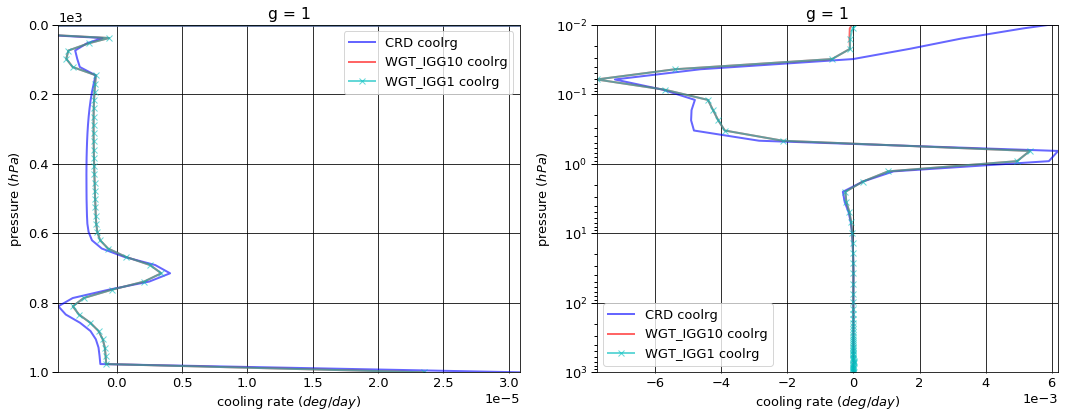

# Figure: cooling rate g-group 2

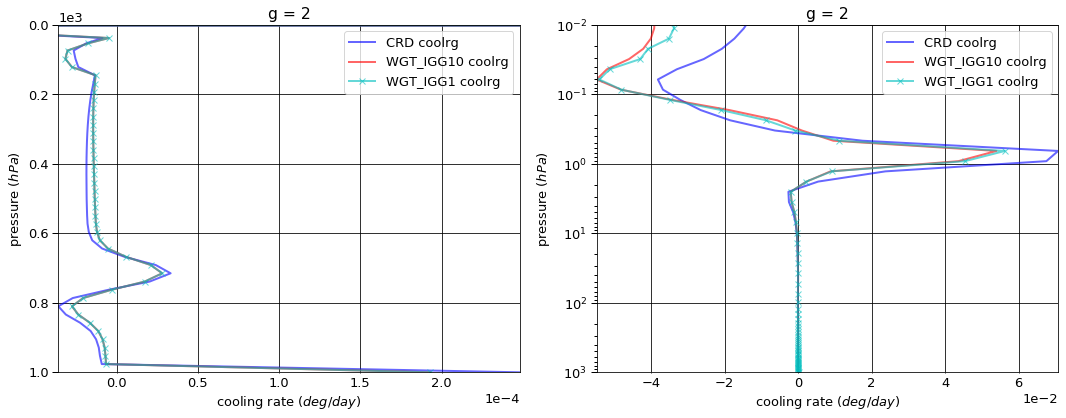

# Figure: cooling rate g-group 3

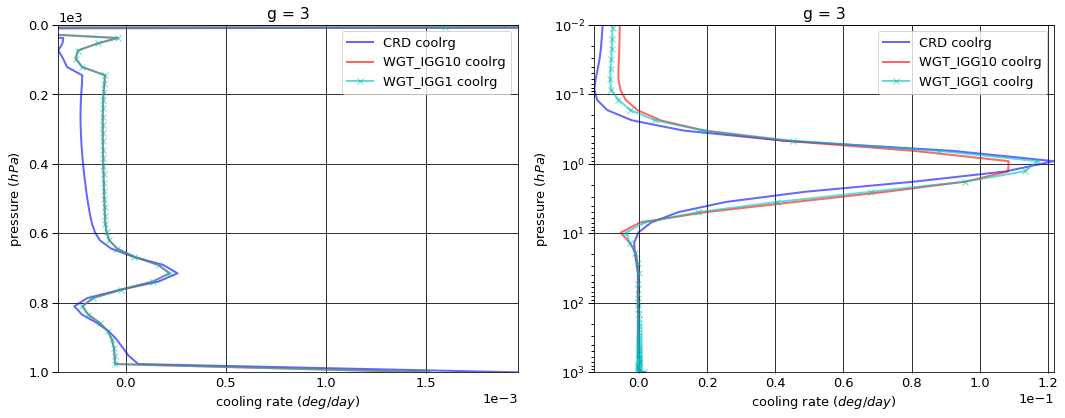

# Figure: cooling rate g-group 4

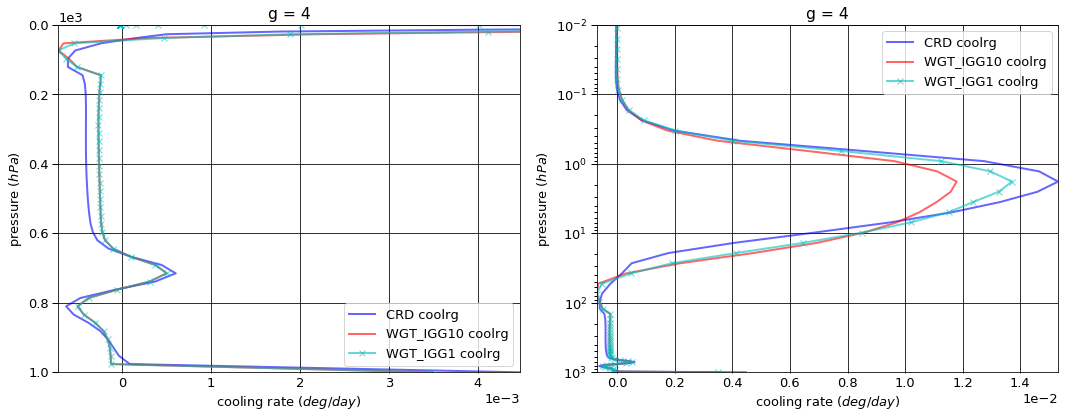

# Figure: cooling rate g-group 5

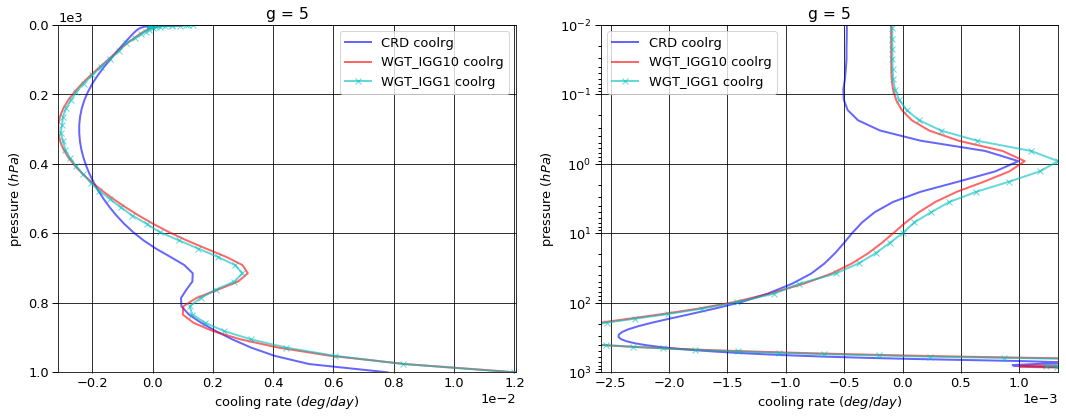

# Figure: cooling rate g-group 6

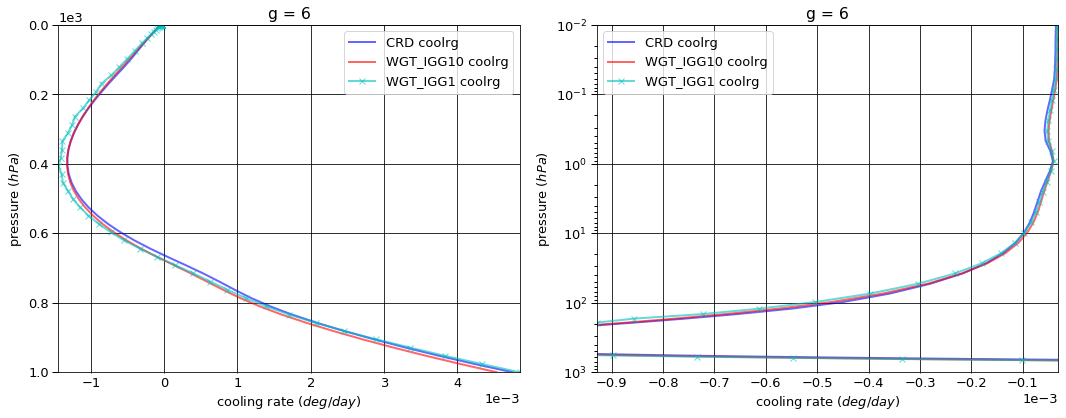

# Figure: cooling rate g-group total

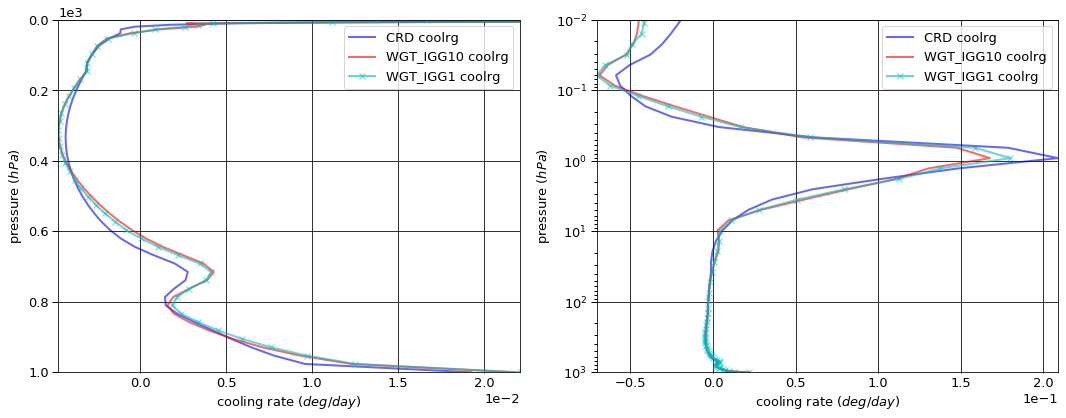

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000038  0.000000 -0.000038
  1013.0   76    -0.003890  0.003799 -0.000090
2 0.0      1     -0.003637  0.000000 -0.003637
  1013.0   76    -0.031418  0.030690 -0.000729
3 0.0      1     -0.027560  0.000000 -0.027560
  1013.0   76    -0.242529  0.231809 -0.010720
4 0.0      1     -0.017051  0.000000 -0.017051
  1013.0   76    -0.554360  0.536330 -0.018030
5 0.0      1     -0.381139  0.000000 -0.381139
  1013.0   76    -0.919313  0.511008 -0.408306
6 0.0      1     -6.279915  0.000000 -6.279915
  1013.0   76    -6.433629  0.172628 -6.261001


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000043  0.000000 -0.000043
  1013.0   76    -0.003200  0.003131 -0.000069
2 0.0      1     -0.001549  0.000000 -0.001549
  1013.0   76    -0.026240  0.025677 -0.000563
3 0.0      1     -0.031068  0.000000 -0.031068
  1013.0   76    -0.205817  0.201402 -0.004415
4 0.0      1     -0.018612  0.000000 -0.018612
  1013.0   76    -0.473601  0.463442 -0.010159
5 0.0      1     -0.139829  0.000000 -0.139829
  1013.0   76    -0.916753  0.804258 -0.112495
6 0.0      1     -6.418131  0.000000 -6.418131
  1013.0   76    -6.559530  0.151383 -6.408147


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000043  0.000000 -0.000043
  1013.0   76    -0.003200  0.003131 -0.000069
2 0.0      1     -0.001665  0.000000 -0.001665
  1013.0   76    -0.026240  0.025677 -0.000563
3 0.0      1     -0.030925  0.000000 -0.030925
  1013.0   76    -0.205817  0.201402 -0.004415
4 0.0      1     -0.019001  0.000000 -0.019001
  1013.0   76    -0.473601  0.463442 -0.010159
5 0.0      1     -0.153769  0.000000 -0.153769
  1013.0   76    -0.916753  0.791826 -0.124927
6 0.0      1     -6.406511  0.000000 -6.406511
  1013.0   76    -6.559530  0.163690 -6.395840


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000005  0.000000 -0.000005
  1013.0   76     0.000690 -0.000668  0.000022
2 0.0      1      0.002088  0.000000  0.002088
  1013.0   76     0.005179 -0.005013  0.000166
3 0.0      1     -0.003508  0.000000 -0.003508
  1013.0   76     0.036713 -0.030407  0.006306
4 0.0      1     -0.001561  0.000000 -0.001561
  1013.0   76     0.080759 -0.072888  0.007871
5 0.0      1      0.241310  0.000000  0.241310
  1013.0   76     0.002560  0.293250  0.295810
6 0.0      1     -0.138216  0.000000 -0.138216
  1013.0   76    -0.125901 -0.021245 -0.147146


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000005  0.000000 -0.000005
  1013.0   76     0.000690 -0.000668  0.000022
2 0.0      1      0.001972  0.000000  0.001972
  1013.0   76     0.005179 -0.005013  0.000166
3 0.0      1     -0.003365  0.000000 -0.003365
  1013.0   76     0.036713 -0.030407  0.006306
4 0.0      1     -0.001951  0.000000 -0.001951
  1013.0   76     0.080759 -0.072888  0.007871
5 0.0      1      0.227370  0.000000  0.227370
  1013.0   76     0.002560  0.280818  0.283379
6 0.0      1     -0.126596  0.000000 -0.126596
  1013.0   76    -0.125901 -0.008938 -0.134839

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.159023
  1001.112500 75     0.000031
2 0.000312    1     -0.013169
  1001.112500 75     0.000248
3 0.000312    1     -0.009950
  1001.112500 75     0.001957
4 0.000312    1     -0.000033
  1001.112500 75     0.004474
5 0.000312    1     -0.000454
  1001.112500 75     0.007790
6 0.000312    1     -0.000033
  1001.112500 75     0.004760


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.333921
  1001.112500 75     0.000024
2 0.000312    1     -0.045384
  1001.112500 75     0.000193
3 0.000312    1     -0.005556
  1001.112500 75     0.001515
4 0.000312    1     -0.000009
  1001.112500 75     0.003486
5 0.000312    1     -0.000100
  1001.112500 75     0.012044
6 0.000312    1     -0.000029
  1001.112500 75     0.004544


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.326864
  1001.112500 75     0.000024
2 0.000312    1     -0.041339
  1001.112500 75     0.000193
3 0.000312    1     -0.007544
  1001.112500 75     0.001515
4 0.000312    1     -0.000023
  1001.112500 75     0.003486
5 0.000312    1     -0.000092
  1001.112500 75     0.011983
6 0.000312    1     -0.000031
  1001.112500 75     0.004856


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.174899
  1001.112500 75    -0.000007
2 0.000312    1     -0.032215
  1001.112500 75    -0.000055
3 0.000312    1      0.004394
  1001.112500 75    -0.000442
4 0.000312    1      0.000024
  1001.112500 75    -0.000988
5 0.000312    1      0.000354
  1001.112500 75     0.004254
6 0.000312    1      0.000004
  1001.112500 75    -0.000216


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.167841
  1001.112500 75    -0.000007
2 0.000312    1     -0.028170
  1001.112500 75    -0.000055
3 0.000312    1      0.002406
  1001.112500 75    -0.000442
4 0.000312    1      0.000010
  1001.112500 75    -0.000988
5 0.000312    1      0.000362
  1001.112500 75     0.004193
6 0.000312    1      0.000002
  1001.112500 75     0.000096

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.709339,0.000000,-6.709339
1013.0,76,-8.185140,1.486264,-6.698876



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.609232,0.000000,-6.609232
1013.0,76,-8.185140,1.649292,-6.535848



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.611915,0.000000,-6.611915
1013.0,76,-8.185140,1.649168,-6.535972



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.001077e-01,0.000000,0.100108
1013.0,76,-7.399999e-09,0.163028,0.163028



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,9.742462e-02,0.000000,0.097425
1013.0,76,-7.399999e-09,0.162904,0.162904


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.135384
1001.112500,75,0.019260



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.282843
1001.112500,75,0.021805



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.277836
1001.112500,75,0.022057



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.147459
1001.112500,75,0.002546



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.142452
1001.112500,75,0.002797


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000558,0.000391
2,0.004283,0.003206
3,0.032140,0.025145
4,0.071100,0.057861
5,0.076576,0.112002
6,0.815343,0.801395


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,9.525551e-18
2,1.029787e-19
3,1.113282e-21
4,6.014952e-22
5,6.500239e-24
6,3.692901e-32


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,9.525551e-18,NaN,0.000558,0.000391,0.000558,0.000391,1.0
2,1.029787e-19,1.081079e-02,0.004283,0.003206,0.004841,0.003597,1.0
3,1.113282e-21,1.081079e-02,0.032140,0.025145,0.036981,0.028742,1.0
4,6.014952e-22,5.402902e-01,0.071100,0.057861,0.108081,0.086603,50.0
5,6.500239e-24,1.080680e-02,0.076576,0.112002,0.184657,0.198605,50.0
6,3.692901e-32,5.681178e-09,0.815343,0.801395,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
